# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 марта 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 марта, -4 балла после 06:00 13 марта, -6 баллов после 06:00 20 марта

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

# Первое задание - указать фамилию в имени файла

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Пролог: Модуль sklearn
На наших практических занятиях мы будем использовать [sklearn](http://scikit-learn.org/stable/index.html) (scikit-learn) - наиболее популярный модуль для работы с методами машинного обучения и анализа данных.

Этот модуль регулярно обновляется, расширяется и сопровождается примерами использования тех или иных методов. Помимо самих алгоритмов (например k-средних или линейной регрессии) в нем есть множество вспомогательных функций по работе с данными.

# Туториал: Работа с различными типами признаков

Вспомним какие типы признаков могут встретится при описании объектов исследования и как их представить в доступной для обработки компьтером форме

Типы признаков мы будем рассматривать на примере довольно популярного набора данных [titanic](https://www.kaggle.com/c/titanic/download/train.csv) - информации о выживаемости пассажиров после известной трагедии корабля Titanic.

In [ ]:
df_titanic = pd.read_csv('train.csv', sep=',').dropna()
df_titanic.head()

## Бинарные признаки
Это признаки с двумя возможными значениями
* Пол (мужской, женский)
* Выжил (да, нет)

На вход в алгоритмы обычно подаются в виде значений `{0, 1}` (реже в виде `{-1, 1}`)

In [ ]:
# Здесь все нормально
df_titanic.Survived.value_counts()

In [ ]:
# Тут стоит выполнить переобознаение
df_titanic.Sex.value_counts()

In [ ]:
# Например так
df_titanic.Sex = df_titanic.Sex.replace({'male': 0, 'female': 1})
df_titanic.Sex.value_counts()

## Вещественные признаки

* Возраст
* Сумма, потраченная на билет
* Количество родственников на борту

Как правило остаются в том же виде или выполняется **нормализация** признаков, т.е. переход к одинаковой шкале, например:

* $\tilde{x} = \frac{x - \text{mean}(x)}{\text{std}(x)}$
* $\tilde{x} = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}$

## Категориальные признаки

Принимают значения из *неупорядоченного* множества

* Порт погрузки (C = Cherbourg; Q = Queenstown; S = Southampton)
* Точка отправления (St Louis, MO; Montreal, PQ; .. }
* Точка назначения (Chesterville, ON; Roseville, IL; .. }

Обычно такие признаки кодируют с помощью так называемого One Hot Encoding: </br>
для каждой категории создается бинарная маска-столбец, в которой стоит `1` если значение признака равно значению соответствующей категории категории.

Например, для признака "порт погрзки" создается бинарная макска из трех стобцов для каждого из портов: С, Q, S<br/>
Если пассажир заходил на кораблю в порту Southampton, то его признаковое описание будет соответственно: `[0, 0, 1]`

In [ ]:
df_titanic.Embarked.head()

In [ ]:
# Сделать в python это можно несколькими способами:

# 1: Через pandas (не очень рекомендуется)
emb = pd.get_dummies(df_titanic.Embarked, prefix='Embarked', prefix_sep='=')
emb.head()

In [ ]:
# 2: Функционал sklearn
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

emb = df_titanic.loc[:, ['Embarked']].replace({'C': 0, 'Q': 1, 'S': 2}).values
emb_enc = encoder.fit_transform(emb)
emb_enc[:5]

Про другием способы работы с категориальными переменными можно прочитать вот [тут](https://alexanderdyakonov.wordpress.com/2016/08/03/python-%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8/)

## Порядковый признаки

Принимают значения из *упорядоченного* множества

* Класс каюты (1 > 2 > 3)

В зависимости от метода остаются можно оставить в исходном виде или применить OneHotEncoding.

## Текстовые признаки - Bag of words

Для демонстрации возьмем текст стихотворения Блока:

Ночь, улица, фонарь, аптека,<br/>
Бессмысленный и тусклый свет.<br/>
Живи еще хоть четверть века -<br/>
Все будет так. Исхода нет.<br/>

Умрешь - начнешь опять сначала<br/>
И повторится все, как встарь:<br/>
Ночь, ледяная рябь канала,<br/>
Аптека, улица, фонарь.<br/>

Пусть каждая строчка - это будет условный документ. Переведем эти документы в числовое представление по методу мешка слов (Bag Of Words)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = \
[u'Ночь, улица, фонарь, аптека,',
 u'Бессмысленный и тусклый свет.',
 u'Живи еще хоть четверть века -',
 u'Все будет так. Исхода нет.',
 u'Умрешь - начнешь опять сначала',
 u'И повторится все, как встарь:',
 u'Ночь, ледяная рябь канала,',
 u'Аптека, улица, фонарь.']

In [ ]:
vect = CountVectorizer()

bow = vect.fit_transform(corpus)
bow = bow.toarray()
bow.shape

Получили матрицу размера $8 \times 27$, так как у нас 8 строчек и выделилось 27 униальных слов. Элемент матрицы показывает сколько раз слово встречалось в соответствующем документе.

In [ ]:
bow

In [ ]:
# Посмотрим какие слова стоят по столбцам
for i, w in enumerate(vect.get_feature_names()):
    print u'столбец %d: %s' % (i, w)

# Туториал: Имплементация собственного метода

Для решения задач вида "имплементируйте метод X" крайне желательно (но необязательно) реализовывать методы с помощью интерфейса sklearn. Ниже вы увидите пример очень простого **классификатора**. Используйте эти наработи для выполнения задания.

Загрузите [датасет](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) с информацией о характеристиках вина и его качестве. (В метод `pd.read_csv()` можно подать веб-ссылку на данные и пандас их скачает и преобразует в `DataFrame`).

In [ ]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [ ]:
df_wine.head()

Наша задача состоит в предсказании целевого признака `quality` по остальным признакам. `quality` - это вещественная переменная (оценка качества от 0 до 10). Упростим себе задачу - создадим новый столбец `quality_cat` по следующим правилам:

* `quality_cat = 1` если `quality > 5` 
* `quality_cat = 0` - иначе 

Таким образом, `quality_cat` характерует "плохое" и "хорошее" вино.

In [ ]:
def prepocess_wine(df):
    df.loc[:, 'quality_cat'] = (df.loc[:, 'quality'] > 5).astype(int)
    df = df.drop('quality', axis=1)
    
    return df

In [ ]:
df_wine = df_wine.pipe(prepocess_wine)
df_wine.head()

Нарисуем распределение хорошего и плохого вина по признаку `alcohol`.

In [ ]:
_, ax = plt.subplots(1,1)
df_wine.query('quality_cat == 1').hist('alcohol', alpha=0.3, bins=20, label='good', ax=ax)
df_wine.query('quality_cat == 0').hist('alcohol', alpha=0.3, bins=20, label='bad', ax=ax)
ax.set_xlabel('alcohol')
ax.set_ylabel('count')
plt.legend()

Визуально кажется, что можно найти некоторое пороговое значение признака `alcohol` $\theta$, чтобы хорошо дискриминировать между плохими и хорошим вином:
* Если `alcohol >` $\theta$ - то предсказываем, что вино хорошее
* Если `alcohol <=` $\theta$ - то предсказываем, что вино плохое

Обучаеть классификатор будем очень просто: перебирать значения признака alchol и считать **ошибку** классификации. То значение, где ошибка минимальна и будет оптимальным.

Разделим целевой признак от остальных признаков

In [ ]:
X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values

Далее вы увидете пример реализации этого простого классификатора.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleClassifier(BaseEstimator, ClassifierMixin): 
    
    def __init__(self):
        """
        Инициализация метода
        """
        
        self.threshold = 0

    def fit(self, X, y=None):
        """
        Выполняет процедуру обучения классификатора. В данном случае - перебор занчения признака alcohol.
        Договоримся, что признак alcohol будет в последнем столбце матрицы X
        """
        
        alcohol = X[:,-1]
        n = float(y.shape[0])
        
        # Задаем пространство поиска
        alco_range = np.arange(alcohol.min(), alcohol.max(), 0.1)
        
        min_error_rate = 1
                
        #  Начинаем поиск
        for theta in alco_range:
            prediction = alcohol > theta
            
            error_rate = sum(prediction != y)/n
            
            if error_rate < min_error_rate:
                min_error_rate = error_rate
                self.threshold = theta  
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания класса по обученному порогу
        """
        
        return (X[:,-1] > self.threshold).astype(int)

Обучаем модель

In [ ]:
model = SimpleClassifier()
model.fit(X, y)

print 'Оптимальный порог: %f' % model.threshold

Получаем предсказание модели (на обучающей выборке)

In [ ]:
y_hat = model.predict(X)

Оценим долю ошибок на обучающей выборке

In [ ]:
error_rate = sum(y_hat != y)/float(y.shape[0])
print 'Доля ошибок на обучающей выборке: %f' % error_rate

## Проверка метода на контрольной выборке

Мы обучили наш метод на данных о красном виде. 

Посмотрим, выполняется ли так же хорошо закономерность между качеством и уровнем алкоголя в белом вине.

In [ ]:
df_wine_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
                           sep=';')

df_wine_test = df_wine_test.pipe(prepocess_wine)
df_wine_test.head()

In [ ]:
X_test, y_test = df_wine_test.iloc[:, :-1].values, df_wine_test.iloc[:, -1].values
y_hat = model.predict(X_test)

In [ ]:
error_rate = sum(y_hat != y_test)/float(y_test.shape[0])
print 'Доля ошибок на контрольной выборке: %f' % error_rate

Получилось неплохо и это лишь наивный алгоритм на одном признаке! Ну а выводы делайте сами =)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.</br> При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

#### Задание 1 (5 баллов)

Имплементируйте метод k-means

In [1]:
from sklearn.base import ClusterMixin, BaseEstimator
import numpy as np


class Kmeans(BaseEstimator, ClusterMixin):
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """

        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0], dtype=int)

        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))

        ## Your Code Here

        metricF = self.metric if callable(self.metric) else self._euclideanMetric

        # Получение минимальных и максимальных координат
        minmax=np.column_stack((np.amin(X,axis=0),np.amax(X,axis=0)))

        # Инициализация центройдов
        self.centroids=X[np.random.choice(range(X.shape[0]),self.k)]

        # Инициализация массива с метками кластеров для каждого объекта из X
        self.labels.fill(-1)

        changed = True  # Если распределение исходной выборки по кластерам не поменялось то False иначе True
        iter = 0
        while (iter < self.max_iter and changed):
            changed = False
            # Нахождение ближайшего центройда
            for i, x in enumerate(X):
                nearestCentroidIndex = 0
                nearestDistance = metricF(x, self.centroids[0])
                for j, c in enumerate(self.centroids[1:]):
                    dist = metricF(x, c)
                    if nearestDistance > dist:
                        nearestDistance = dist
                        nearestCentroidIndex = j+1
                if self.labels[i] != nearestCentroidIndex: changed = True
                self.labels[i] = nearestCentroidIndex

            # Обновление положения центройдов
            self.centroids.fill(0)
            counter = np.full(self.k, 0, dtype=int)
            for xi, ci in enumerate(self.labels):
                counter[ci] += 1
                self.centroids[ci] += X[xi]
            centroidIds=np.arange(self.k)
            zeroIds=centroidIds[counter==0]
            nonZeroIds=centroidIds[counter!=0]
            self.centroids[nonZeroIds] /= counter[nonZeroIds, np.newaxis]

            if len(zeroIds):
                for j in range(X.shape[1]):
                    self.centroids[zeroIds, j] = np.random.uniform(minmax[j][0], minmax[j][1], zeroIds.shape[0])


            iter += 1

        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера

        Возвращает метку ближайшего кластера для каждого объекта
        """
        metricF = self.metric if callable(self.metric) else self._euclideanMetric
        res = np.empty(X.shape[0], dtype=int)
        # Нахождение ближайшего центройда
        for i, x in enumerate(X):
            nearestCentroidIndex = 0
            nearestDistance = metricF(x, self.centroids[0])
            for j, c in enumerate(self.centroids[1:]):
                    dist = metricF(x, c)
                    if nearestDistance > dist:
                        nearestDistance = dist
                        nearestCentroidIndex = j+1
            res[i] = nearestCentroidIndex
        return res

    # Евклидова метрика
    @staticmethod
    def _euclideanMetric(a, b):
        return np.linalg.norm(a-b)

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, желатено испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

In [2]:
from sklearn.datasets import make_blobs

In [3]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

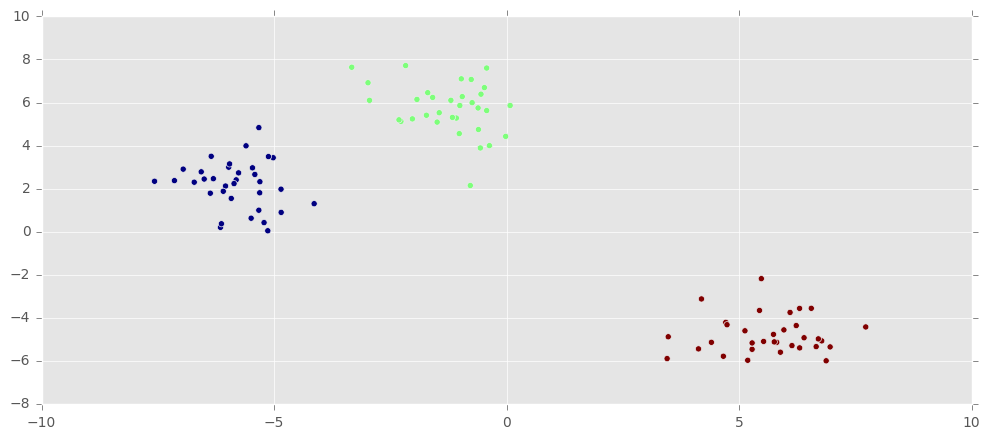

In [6]:
plt.scatter(X[:,0], X[:, 1], c=y)

#### Задание 2 (1 балл) 

Проверьте вашу имплементацию на простых данных

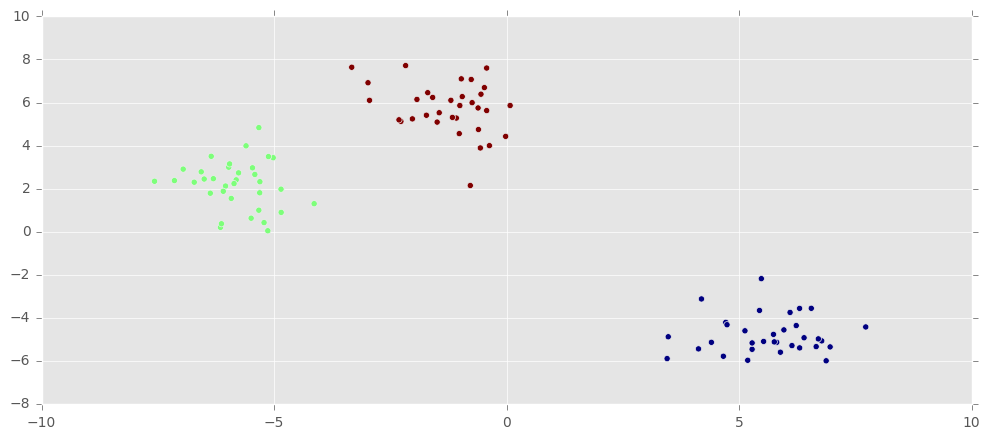

In [7]:
# Your Code Here
km=Kmeans(3)
km.fit(X)
y2=km.predict(X)
plt.scatter(X[:,0], X[:, 1], c=y2)

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.

In [4]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

#### Задание 3 (4 балла)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)

In [14]:
## Your Code Here
df_sns=df_sns.drop(["gradyear","gender","age","friends"],axis=1)

for i in df_sns.columns:
    mean=df_sns[i].mean()
    std=df_sns[i].std()
    df_sns[i]=(df_sns[i]-mean)/std

clusterCount=9
km=kmeans.Kmeans(clusterCount)
km.fit(df_sns.values)

xclusters=km.labels
centers=km.centroids

Отсеем большие и маленькие кластеры

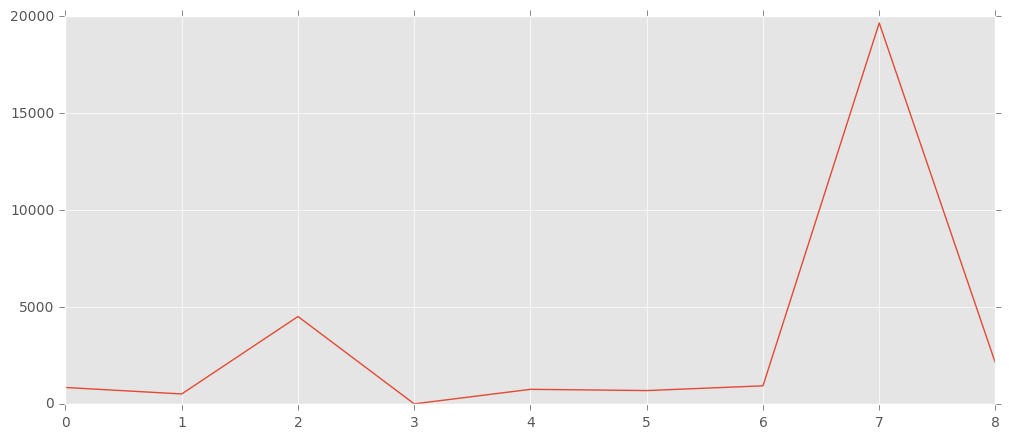

In [15]:
cweights=np.zeros(centers.shape[0],dtype=int)
unique, counts = np.unique(xclusters, return_counts=True)
cweights[unique]=counts
plt.plot(cweights)

In [26]:
minElements=df_sns.shape[0]/float(clusterCount)/5
maxElements=df_sns.shape[0]/float(clusterCount)*5
goodClusters=np.arange(clusterCount)[(cweights>minElements)*(cweights<maxElements)]
goodClusters

array([0, 2, 4, 5, 6, 8])

Попробуем выделить наиболее значимые признаки для кластеров, по идее у таких признаков должно быть небольшое стандартное отклонение в пределах кластера или сильно отличающееся среднее зачение от других кластеров

In [102]:
pd.set_option('display.max_columns', df_sns.shape[1]+1)

df_sns_std=pd.DataFrame(np.empty((clusterCount,df_sns.shape[1])),index=list(range(clusterCount)),columns=df_sns.columns)
df_sns_mean=pd.DataFrame(np.empty((clusterCount,df_sns.shape[1])),index=list(range(clusterCount)),columns=df_sns.columns)

for i in range(clusterCount):
    df_sns_std.loc[(i)]=df_sns[xclusters==i].std()
    df_sns_mean.loc[(i)]=centers[i]

df_sns_std.loc[goodClusters]

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,cute,sex,sexy,hot,kissed,dance,band,marching,music,rock,god,church,jesus,bible,hair,dress,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,1.037290,1.227023,0.825418,0.816838,1.306555,1.410421,1.670413,0.769470,1.457237,0.998990,1.422535,0.701788,1.054519,1.646120,1.043184,1.308790,0.514582,0.377267,0.999142,0.996322,0.632705,0.786589,0.692345,0.442650,1.451054,1.260317,0.347981,1.758984,1.481453,1.829467,2.865887,3.174254,0.910373,1.044565,1.024917,0.875756
2,0.748632,0.932740,0.455237,0.562165,0.702614,1.662258,1.844029,0.527674,1.197764,0.731248,1.671639,0.598961,1.779206,1.808990,0.649019,1.876659,0.673509,0.242711,1.252724,1.145080,0.838652,1.483496,0.714847,0.229867,1.111354,1.925738,0.276355,1.674396,1.550041,1.536821,0.672201,0.639425,0.896877,1.168491,0.997847,0.631850
4,0.689427,0.969030,0.503315,0.675726,0.867273,0.989178,0.611849,0.439140,1.369351,0.826577,0.823770,0.631958,0.847088,0.817588,0.726429,0.955904,3.808201,3.685195,1.330873,1.163850,0.819686,0.938798,0.731764,0.469876,0.761964,0.942076,0.230762,0.819811,0.910086,0.907400,0.296234,0.411285,0.820322,0.965839,0.646068,0.644850
5,1.077467,1.295877,2.748468,0.688130,1.146349,1.028025,0.931430,0.797134,1.183486,1.396438,0.989216,0.446336,0.893890,1.035417,0.619351,0.790370,0.663448,0.417180,0.833417,1.203074,0.689300,1.114992,0.719857,0.613362,0.880989,0.928383,0.458328,1.053989,1.112269,0.762597,0.785111,0.695092,0.826448,0.815900,0.776911,0.620743
6,1.582148,1.385211,0.933629,1.367221,1.103002,1.369346,1.315188,1.094328,1.120602,2.079002,1.651067,4.472994,1.853249,1.606173,3.662686,1.365643,1.119731,0.634592,2.543128,2.723837,1.047858,1.133644,0.775711,0.990049,2.743416,1.637804,0.466147,1.465404,1.259092,2.137348,1.472539,1.421689,3.238730,2.736801,3.066414,3.843732
8,2.361020,2.128298,0.652124,2.867642,2.740548,1.057432,1.129742,3.001646,1.232816,2.175394,0.939992,0.583641,0.909649,0.883383,0.603606,0.794247,0.604643,0.370588,0.812195,1.319096,0.703040,1.135363,0.700460,0.398027,0.921655,0.728909,0.383992,0.957839,0.961389,0.956218,0.541084,0.557443,0.678526,0.792783,0.702763,0.507720


In [103]:
df_sns_mean.loc[goodClusters]

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,cute,sex,sexy,hot,kissed,dance,band,marching,music,rock,god,church,jesus,bible,hair,dress,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,0.116740,0.213080,0.024864,0.005528,0.169300,0.247010,0.403273,0.013853,0.134810,0.086335,0.377437,0.034298,0.114896,0.403537,0.068588,0.234471,-0.097889,-0.108519,0.151831,0.070304,0.004299,-0.021513,-0.007957,-0.063861,0.451720,0.147138,0.065771,0.593936,0.801894,0.577580,4.163195,4.006453,0.051170,0.097967,0.057659,0.036948
2,-0.034077,0.058824,-0.102420,-0.073743,-0.042802,0.280429,0.390183,-0.082554,0.060102,-0.078251,0.807644,0.015119,0.387532,0.530802,-0.024131,0.680022,-0.037694,-0.124427,0.292373,0.160845,0.112826,0.355119,0.017373,-0.093411,0.327806,0.617941,0.019271,0.674750,0.883063,0.538216,-0.035230,-0.064849,0.059189,0.115641,0.050704,-0.052335
4,-0.118754,0.034967,-0.144153,-0.064914,-0.084256,0.046530,-0.114123,-0.111800,0.006214,-0.119042,-0.052226,-0.048900,-0.050522,-0.064131,-0.053601,0.025999,3.392017,4.821358,0.390087,0.150197,0.046155,0.018563,-0.014105,-0.058699,-0.057421,0.016781,-0.016658,-0.107715,-0.081069,-0.035282,-0.170755,-0.144924,-0.019742,0.021982,-0.086951,-0.082414
5,0.159083,0.180136,5.125949,-0.046973,0.051159,0.108333,-0.020810,0.007817,0.095355,0.301456,0.035987,-0.058304,-0.008656,0.072498,-0.059932,-0.028149,-0.045633,-0.090791,0.032927,0.108121,-0.003383,0.098048,-0.012748,-0.026118,0.008306,-0.001116,0.035870,0.045817,0.196910,-0.049721,-0.008669,-0.042648,-0.008520,-0.018610,-0.056523,-0.044499
6,0.345133,0.372466,0.034370,0.124399,0.096575,0.248507,0.164006,0.183450,0.132014,0.768827,0.481482,2.124752,0.516771,0.297850,3.210045,0.429844,0.390112,-0.021823,1.146619,1.182940,0.351741,0.173300,0.061890,0.037316,2.536086,0.519437,0.183840,0.603187,0.235515,1.197724,0.179098,0.269867,1.758304,0.939672,1.854958,2.949066
8,1.545153,1.124934,0.010324,1.469195,1.215275,0.092391,0.084734,1.426755,0.100420,1.068466,-0.016076,-0.026363,-0.005504,-0.000478,-0.067795,-0.017874,-0.074703,-0.101554,0.037226,0.160682,0.008970,0.115266,-0.004922,-0.071622,0.031218,-0.078196,0.041133,0.002949,0.038681,0.021789,-0.107963,-0.101149,-0.066476,-0.023524,-0.074634,-0.097616


Можно попробовать сделать следющие выводы:<br>
0 кластер: очень любят употреблять слова abercrombie и hollister, наверное очень модные<br>
2 кластер: среднестатистический человек<br>
4 кластер: любят беседовать о марширующем оркестре<br>
5 кластер: любят беседовать о футболе<br>
6 кластер: любят употребялть слова "kissed", "drugs"<br>
8 кластер: любят softball, basketball, baseball